# Classification on CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [1]:
""" Get Data """

# File Path
CIFAR_DIR = 'cifar-10-batches-py/'

# Load the Data
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [2]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [3]:
all_data = [0,1,2,3,4,5,6]

In [4]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [5]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [6]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [7]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


Loaded in this way, each of the batch files contains a dictionary with the following elements:

data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.
The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

In [9]:
# Display the Data Images
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [10]:
X = data_batch1[b"data"] 
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [11]:
X[0].max()

255

In [12]:
(X[0]/255).max()

1.0

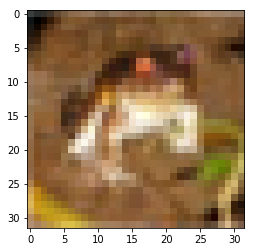

In [13]:
plt.imshow(X[0])

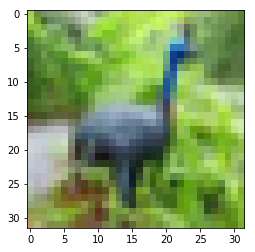

In [14]:
plt.imshow(X[6])

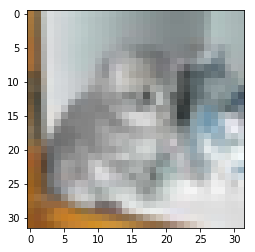

In [15]:
plt.imshow(X[36])

## Helper Functions for Dealing With Data.

In [16]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [17]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

## Creating the Model